# <a id='toc1_'></a>[Projet 4, Partie 2 - Construisez un modèle de scoring](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Projet 4, Partie 2 - Construisez un modèle de scoring](#toc1_)    
  - [Train](#toc1_1_)    
  - [Test](#toc1_2_)    
    - [Resultat LDA](#toc1_2_1_)    
    - [Resultat LGM](#toc1_2_2_)    
    - [Resultat NB](#toc1_2_3_)    
- [Optimisation des hyperparametres](#toc2_)    
  - [Optuna](#toc2_1_)    
- [Explication du modèle avec SHAP](#toc3_)    
  - [SHAP](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Comme nous l'avons vu dans la partie 1 (voir notebook précedant) notre choix de modèle c'est porte sur les modèles ayant les meilleures metriques a savoir: 

- Linear Discriminant Analysis (LDA)
- LightGBM (LGB)
- Naive Bayes (NB)

Pourquoi ? 

- LDA a les meilleures performance global (AUC, F1, Kappa, MCC)
- LGB a la meilleure precision et une des meilleure Accuracy
- NB a le meilleures recall


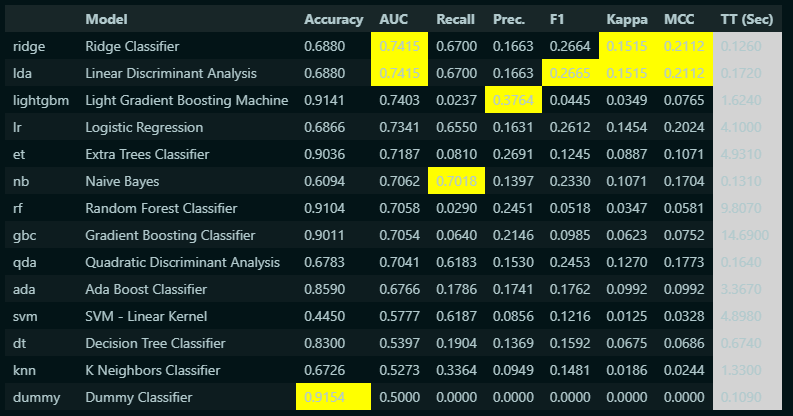

In [221]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.naive_bayes import MultinomialNB, GaussianNB  
from lightgbm import LGBMClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE 
import optuna
import logging
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.metrics import  make_scorer

In [222]:
df_origin = pd.read_csv('../data/application_train.csv')
df = df_origin.copy()

In [223]:
class scoringCredit:
    def __init__(self, data , preprocessing_type: str):
        self.data = data
        self.preprocessing_type = preprocessing_type
        self.feature_importance_columns = None
        self.columns_without_context = [
            'SK_ID_CURR',
            'NAME_CONTRACT_TYPE',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'DAYS_ID_PUBLISH',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'DAYS_LAST_PHONE_CHANGE',
            'WEEKDAY_APPR_PROCESS_START',
            # 'OCCUPATION_TYPE'


        ]
        
    
    def handleMissingValues(self):
        try:
            # Calcul des valeurs manquantes par columns en %
            missing_percent_cols = (self.data.isna().sum() / len(self.data)) * 100

            # Crée une liste des colonnes ayant plus de 50% de valeurs manquantes
            drop_cols = missing_percent_cols[missing_percent_cols > 40]

            #  supressino des colonnes dans le dataframe
            self.data = self.data.drop(list(drop_cols.index), axis=1)

            # Recuperer toutes les colonnes qui ont encore des valeurs manquantes

            #Imputation avec knn imputer


            self.data = self.data.dropna()

            return self.data

        except Exception as error:
            raise error

        return f'Sucessfuly Delete: {list(drop_cols.index)}'


    def handleCategoricalsData(self):
        try:
            # Features Binaires
            binary_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

            # Traitement de CODE_GENDER pour supprimer xna
            if 'CODE_GENDER' in self.data.columns:
                self.data['CODE_GENDER'] = self.data['CODE_GENDER'].replace('XNA', pd.NA)

            # Convertir les variables binaires avec get_dummies
            self.data[binary_features] = pd.get_dummies(self.data[binary_features], drop_first=True).astype(int)

            # Features pour target encoding
            target_encoding_features = ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']
            for feature in target_encoding_features:
                if feature in self.data.columns:
                    target_mean = self.data.groupby(feature)['TARGET'].mean()
                    self.data[feature] = self.data[feature].map(target_mean)

            return self.data

        except Exception as error:
            raise error

        
    def featuresOptimisation(self):
        try:
            # Étape 1 : Colonnes FLAG
            flag_columns = self.data.filter(like='FLAG').columns
            self.data['FLAGS'] = self.data[flag_columns].sum(axis=1)
            self.data.drop(columns=flag_columns, inplace=True)

            # Étape 2 : Colonnes REGION
            region_columns = self.data.filter(like='REGION').columns.tolist()
            additional_region_columns = ['REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']
            region_columns = [col for col in additional_region_columns if col in self.data.columns] + region_columns
            if region_columns: 
                self.data['REGION_SCORE'] = self.data[region_columns].sum(axis=1)
                self.data.drop(columns=region_columns, inplace=True)

            # Étape 3 : Calcul des ratios pour les colonnes AMT
            self.data['INCOME_CREDIT_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_CREDIT']
            self.data['ANNUITY_CREDIT_RATIO'] = self.data['AMT_ANNUITY'] / self.data['AMT_CREDIT']
            self.data['CREDIT_POSSESSION_RATIO'] = self.data['AMT_CREDIT'] / self.data['AMT_GOODS_PRICE']
            self.data['INCOME_ANNUITY_RATIO'] = self.data['AMT_INCOME_TOTAL'] / self.data['AMT_ANNUITY']

            # Étape 4 : PCA sur les colonnes AMT
            amt_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
            amt_columns = [col for col in amt_columns if col in self.data.columns]
            self.data.dropna(subset=amt_columns, inplace=True)

            if amt_columns: 
                scaler = StandardScaler()
                pca = PCA(n_components=1)
                self.data['AMT_PCA'] = pca.fit_transform(scaler.fit_transform(self.data[amt_columns]))

            # Étape 5 : Traitement spécifique pour TRAIN
            if getattr(self, 'preprocessing_type', None) == 'TRAIN':

                # Supprimer les valeurs manquantes restantes
                self.data = self.data.dropna()

                X = self.data.drop('TARGET', axis=1)
                y = self.data['TARGET']


                # Features selection avec SelectKBest
                num_selector = SelectKBest(score_func=f_classif, k='all').fit(X, y)

                # Scores des features
                scores = num_selector.scores_

                feature_scores = pd.DataFrame({
                    'Feature': np.array(X.columns),
                    'Score': scores
                })

                # Trier par importance
                feature_scores = feature_scores.sort_values(by='Score', ascending=False)

                # Retourner les 15 features les plus importantes
                self.feature_importance_columns = feature_scores[:20].Feature

                return X[self.feature_importance_columns], y
            else:
                y = self.data['TARGET']

            return self.data[self.feature_importance_columns], y

        except Exception as error:
            raise error

    

    def preprocessing(self):
        try:
            # Étape 1 : Supprimer les colonnes sans contexte métier
            self.data = self.data.drop(self.columns_without_context, axis=1, errors='ignore')

            # Étape 2 : Gestion des valeurs manquantes
            self.data = self.handleMissingValues()

            # Étape 3 : Gestion des données qualitatives
            self.data = self.handleCategoricalsData()

            # Étape 4 : Feature engineering & selection
            X, y = self.featuresOptimisation()

            return X, y

        except Exception as error:
            # Ajouter plus de contexte à l'erreur
            raise RuntimeError(f"Error in preprocessing step: {error}") from error


    

    def compute_class_weights(self, y_train, imbalance_factor=10):
        """
        Calcule les poids de classe pour que la classe minoritaire soit pondérée 15 fois plus.
        Retourne un dictionnaire utilisable dans les modèles acceptant class_weight.
        """
        class_counts = np.bincount(y_train)
        len(y_train)
        # Calcul des poids pour chaque classe
        class_weights = {0: 1, 1: 1}  # Initialise avec des valeurs par défaut

        if len(class_counts) == 2:  # S'assure qu'il y a bien deux classes
            minority_class = np.argmin(class_counts)
            majority_class = np.argmax(class_counts)

            class_weights[majority_class] = 1
            class_weights[minority_class] = imbalance_factor

        return class_weights

    def train(self, model, X_train, y_train, imbalance_factor=10):
        try:
            # Calculer les poids de classe personnalisés
            class_weights = self.compute_class_weights(y_train, imbalance_factor)
            print(f"Class Weights: {class_weights}")

            # Modèles supportant class_weight directement
            if hasattr(model, 'class_weight'):
                model.set_params(class_weight=class_weights)
                model.fit(X_train, y_train)

            # Pour LightGBM
            elif isinstance(model, LGBMClassifier):
                scale_pos_weight = class_weights[1] / class_weights[0]
                model.set_params(scale_pos_weight=scale_pos_weight)
                model.set_params(verbosity=-1)
                model.fit(X_train, y_train)

            # Pour Naive Bayes
            elif isinstance(model, GaussianNB):
                # Appliquer des priors basés sur les poids de classe
                total = sum(class_weights.values())
                priors = [class_weights[cls] / total for cls in sorted(class_weights.keys())]
                model.set_params(priors=priors)
                model.fit(X_train, y_train)

            elif isinstance(model, MultinomialNB):
                # MultinomialNB ne supporte pas les priors pondérés explicitement
                raise ValueError("MultinomialNB does not support class weighting")

            # Pour Linear Discriminant Analysis (LDA)
            elif isinstance(model, LinearDiscriminantAnalysis):
                # Utilisation de SMOTE car class_weight n'est pas supporté
                smote = SMOTE(random_state=42)
                X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
                model.fit(X_train_res, y_train_res)

            else:
                raise ValueError("Unsupported model for custom class weighting.")

            return model

        except Exception as error:
            raise RuntimeError(f"Error in training with custom weights: {error}") from error

In [224]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, 
    cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, 
    precision_recall_curve, confusion_matrix, auc
)


# Fonction pour calculer la métrique personnalisé
def custom_metric(y_true, y_pred, weight=100 ,minority_class=1):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    

    minority_ratio = np.mean(y_true == minority_class)
    fn_penalty = fn * weight * minority_ratio


    # Calculer le coût total en incluant les faux positifs
    total_cost = fn_penalty + fp

    return -total_cost  # Retourner la valeur négative pour maximiser avec Optuna


def displayMetrics(model, X_test, y_test, cv=10, confidence=0.5):
    # Prédictions avec validation croisée
    y_pred = cross_val_predict(model, X_test, y_test, cv=cv)
    y_proba = cross_val_predict(model, X_test, y_test, cv=cv, method="predict_proba")[:, 1] if hasattr(model, "predict_proba") else y_pred

 # Prédictions avec le seuil optimisé
    y_pred_opt = (y_proba >= confidence).astype(int)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall = recall_score(y_test, y_pred_opt)
    precision = precision_score(y_test, y_pred_opt)
    kappa = cohen_kappa_score(y_test, y_pred_opt)
    mcc = matthews_corrcoef(y_test, y_pred_opt)
    cm = custom_metric(y_test, y_pred_opt)

    # Vérification de la classification binaire pour AUC et PR AUC
    is_binary = len(np.unique(y_test)) == 2
    auc_score = roc_auc_score(y_test, y_proba) if is_binary else None
    
    # Precision-Recall AUC
    if is_binary:
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall_vals, precision_vals)
    else:
        pr_auc = None

    # Affichage des métriques
  
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Custom Metric: {cm:.4f}")

    if is_binary:
        print(f"ROC AUC: {auc_score:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("AUC: Non applicable pour une classification multiclass")

    # Création des subplots
    n_plots = 3 if is_binary else 1
    fig, axes = plt.subplots(1, n_plots, figsize=(20, 6))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_opt)
    classes = np.unique(y_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0] if is_binary else axes, 
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title("Matrice de confusion", fontsize=16)
    axes[0].set_xlabel("Prédictions", fontsize=12)
    axes[0].set_ylabel("Véritables classes", fontsize=12)
    
    # Courbe ROC pour les problèmes binaires
    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
        axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.0])
        axes[1].set_xlabel("False Positive Rate (FPR)")
        axes[1].set_ylabel("True Positive Rate (TPR)")
        axes[1].set_title("ROC Curve", fontsize=16)
        axes[1].legend(loc="lower right")
        
        # Courbe Precision-Recall
        axes[2].plot(recall_vals, precision_vals, label=f"PR Curve (AUC = {pr_auc:.2f})", color='green')
        axes[2].set_xlim([0.0, 1.0])
        axes[2].set_ylim([0.0, 1.0])
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].set_title("PR-AUC", fontsize=16)
        axes[2].legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

    return y_pred_opt


## <a id='toc1_1_'></a>[Train](#toc0_)

In [225]:
from sklearn.model_selection import train_test_split

X = df.drop('TARGET', axis=1)
Y = df.TARGET

# Effectuer la division
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Concaténer X_train et y_train
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(61503, 121) (61503,)
(246008, 121) (246008,)


In [226]:
# initialiser la classe
SC = scoringCredit(df_train, 'TRAIN')

# Appliquer le preprocessing au df
X_train,y_train = SC.preprocessing()

In [227]:
# Entrainement du modele LDA
LDA = SC.train(LinearDiscriminantAnalysis(), X_train, y_train)

Class Weights: {0: 1, 1: 10}


In [228]:
# Entrainement du modele LGM
LGM = SC.train(LGBMClassifier(), X_train, y_train)

Class Weights: {0: 1, 1: 10}


In [229]:
NB = SC.train(GaussianNB(), X_train, y_train)

Class Weights: {0: 1, 1: 10}


## <a id='toc1_2_'></a>[Test](#toc0_)

In [230]:
# Definir les nouveaux parametre de classe pour les données de test
SC.preprocessing_type = 'TEST'
SC.data = df_test
print(SC.preprocessing_type, len(SC.data.columns), SC.data.shape)

# Appliquer le preprocessing sur les données de test
X_test,y_test = SC.preprocessing()

# Afficher la taille de X et y
X_test.shape, y_test.shape

TEST 122 (61503, 122)


((33683, 20), (33683,))

### <a id='toc1_2_1_'></a>[Resultat LDA](#toc0_)

Accuracy: 0.9147
F1 Score: 0.0521
Recall: 0.0275
Precision: 0.4938
Cohen's Kappa: 0.0435
MCC: 0.1011
Custom Metric: -23862.0468
ROC AUC: 0.7456
PR AUC: 0.2349


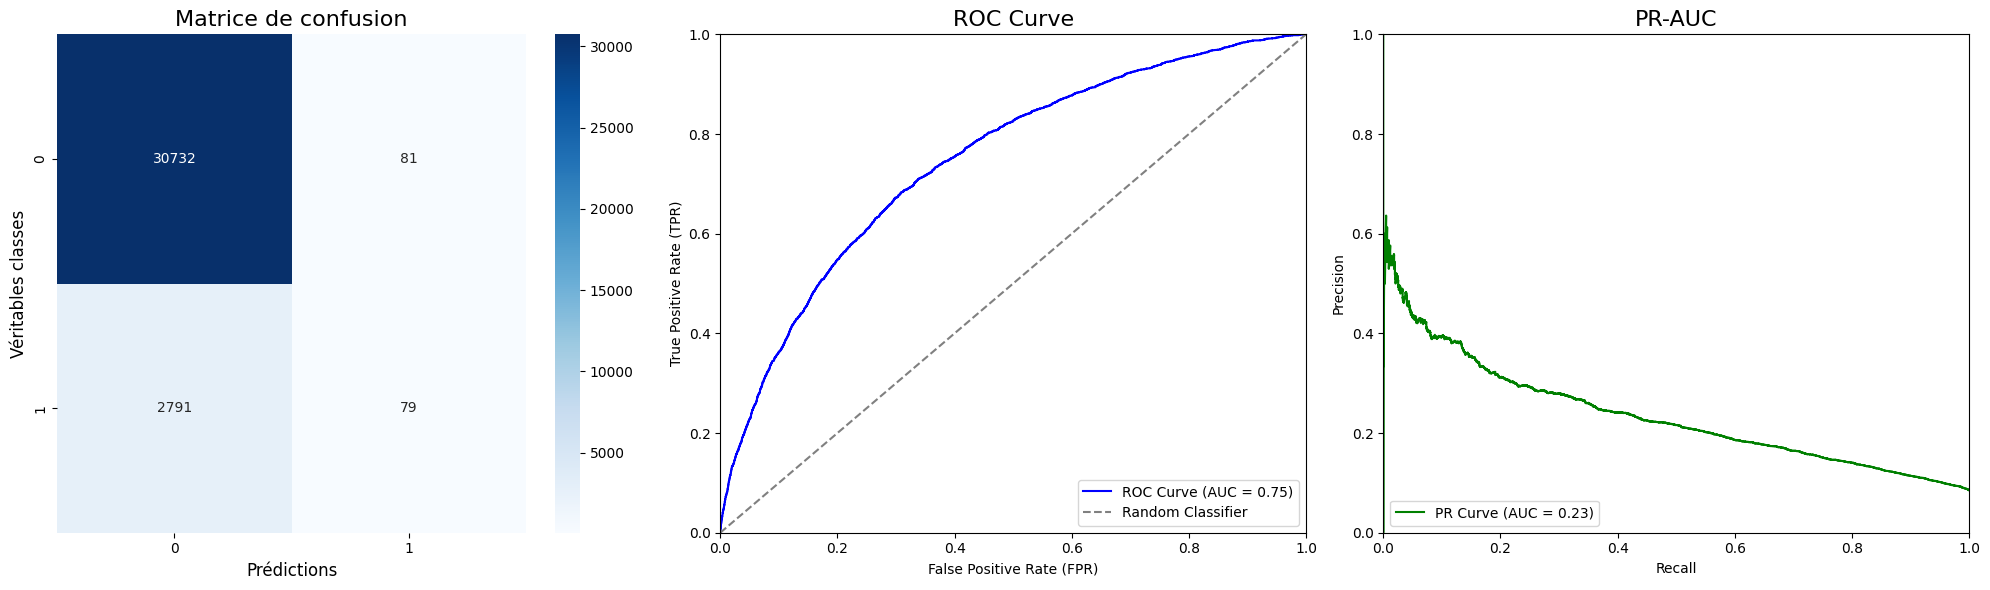

In [231]:
y_pred_lda = displayMetrics(LDA, X_test, y_test)

### <a id='toc1_2_2_'></a>[Resultat LGM](#toc0_)

c:\Users\223115316\Documents\GitHub\OC\Projet4\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\223115316\Documents\GitHub\OC\Projet4\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

Accuracy: 0.7634
F1 Score: 0.2858
Recall: 0.5557
Precision: 0.1924
Cohen's Kappa: 0.1823
MCC: 0.2193
Custom Metric: -17559.7889
ROC AUC: 0.7390
PR AUC: 0.2298


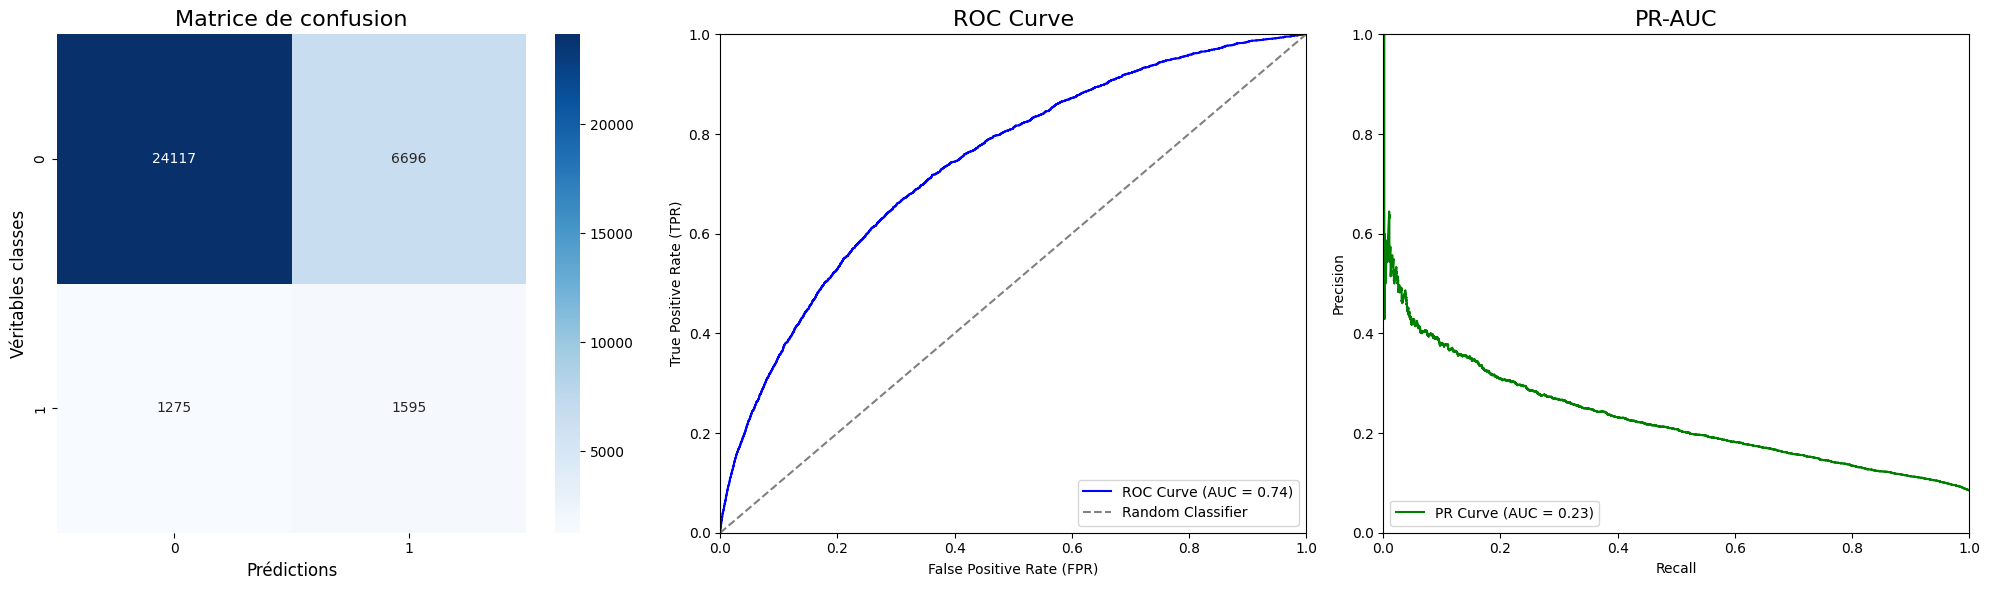

In [232]:
y_pred_lgm = displayMetrics(LGM, X_test, y_test)

### <a id='toc1_2_3_'></a>[Resultat NB](#toc0_)

Accuracy: 0.8220
F1 Score: 0.0951
Recall: 0.1098
Precision: 0.0838
Cohen's Kappa: -0.0017
MCC: -0.0017
Custom Metric: -25212.1808
ROC AUC: 0.5811
PR AUC: 0.1013


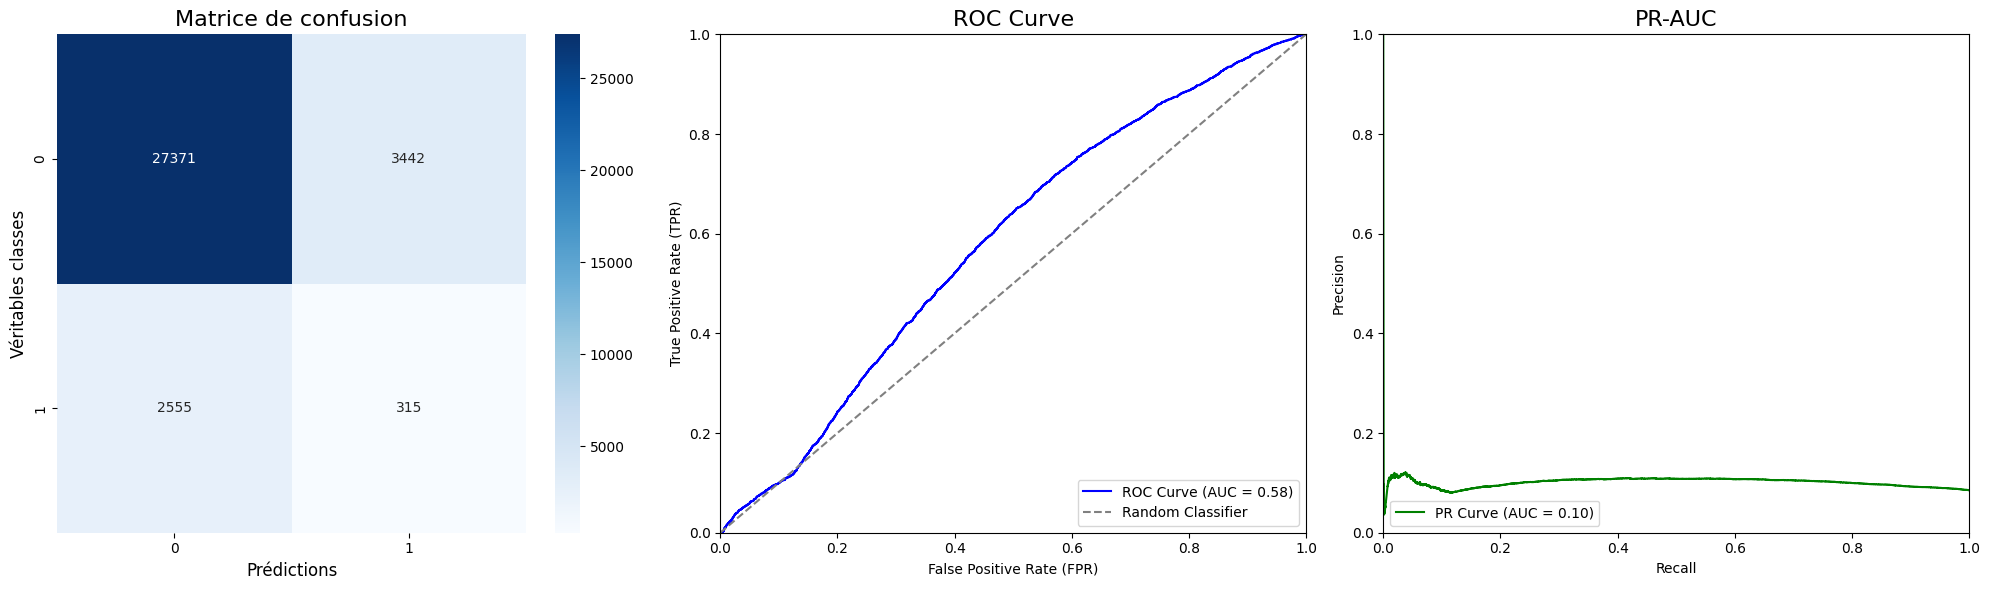

In [233]:
y_pred_nb = displayMetrics(NB, X_test, y_test)

Le modèle qui obtient les meilleures resultat est donc pour le moment LGM qui obtient les meilleures metrics, cependant ce n'est pas un modèle qui est très optimal et performant, nous allons donc passer a la deuxieme etape, l'optimisation des hyperparamètres pour voir si nous pouvons avoir une amelioration significative de notre modèle 

# <a id='toc2_'></a>[Optimisation des hyperparametres](#toc0_)

## <a id='toc2_1_'></a>[Optuna](#toc0_)

In [234]:
# Fonction objective à optimiser
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimeters', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'verbosity' : -1
    }
    
    model = LGBMClassifier(**param)
    # Créer un scoreur pour la métrique personnalisée
    custom_scorer = make_scorer(custom_metric, greater_is_better=False)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=custom_scorer)
    return scores.mean()

# Configurer le logger d'Optuna pour limiter les logs
optuna.logging.set_verbosity(optuna.logging.CRITICAL)  # Limiter l'affichage des logs à WARNING

# Créer l'étude (study)
study = optuna.create_study(direction='maximize')

# Optimisation
study.optimize(objective, n_trials=20)

# Afficher les meilleurs paramètres
print("Best parameters:", study.best_params)
print("Best Custom Metric:", study.best_value)

# Afficher l'historique des essais
print("Trial results:")
for trial in study.trials:
    print(f"Trial {trial.number}: Value {trial.value}, Params {trial.params}")


C:\Users\223115316\AppData\Local\Temp\ipykernel_19896\2381799331.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\223115316\AppData\Local\Temp\ipykernel_19896\2381799331.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\223115316\AppData\Local\Temp\ipykernel_19896\2381799331.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),

Best parameters: {'num_leaves': 42, 'learning_rate': 0.011083401739525212, 'n_estimeters': 114, 'min_child_samples': 25, 'subsample': 0.9983490567165505, 'colsample_bytree': 0.6358571701882711}
Best Custom Metric: 31978.853038608373
Trial results:
Trial 0: Value 31789.78060519631, Params {'num_leaves': 56, 'learning_rate': 0.03176464591645964, 'n_estimeters': 103, 'min_child_samples': 48, 'subsample': 0.9461745647437938, 'colsample_bytree': 0.7551480050093486}
Trial 1: Value 30993.005035875034, Params {'num_leaves': 81, 'learning_rate': 0.1458087193956116, 'n_estimeters': 719, 'min_child_samples': 14, 'subsample': 0.5081592378508366, 'colsample_bytree': 0.7627644579310967}
Trial 2: Value 31424.534352392413, Params {'num_leaves': 24, 'learning_rate': 0.023797718624170874, 'n_estimeters': 822, 'min_child_samples': 10, 'subsample': 0.7462956512525434, 'colsample_bytree': 0.8061391794126804}
Trial 3: Value 31221.72917687954, Params {'num_leaves': 29, 'learning_rate': 0.07064887779888997, '

In [235]:
study.best_params

{'num_leaves': 42,
 'learning_rate': 0.011083401739525212,
 'n_estimeters': 114,
 'min_child_samples': 25,
 'subsample': 0.9983490567165505,
 'colsample_bytree': 0.6358571701882711}

In [236]:
# Entrainer le modèle avec les meilleurs params
lgb_optimized = SC.train(LGBMClassifier(**study.best_params), X_train=X_train, y_train=y_train) 

Class Weights: {0: 1, 1: 10}


c:\Users\223115316\Documents\GitHub\OC\Projet4\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\223115316\Documents\GitHub\OC\Projet4\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

Accuracy: 0.7415
F1 Score: 0.2805
Recall: 0.5913
Precision: 0.1838
Cohen's Kappa: 0.1730
MCC: 0.2171
Custom Metric: -17528.6857
ROC AUC: 0.7430
PR AUC: 0.2318


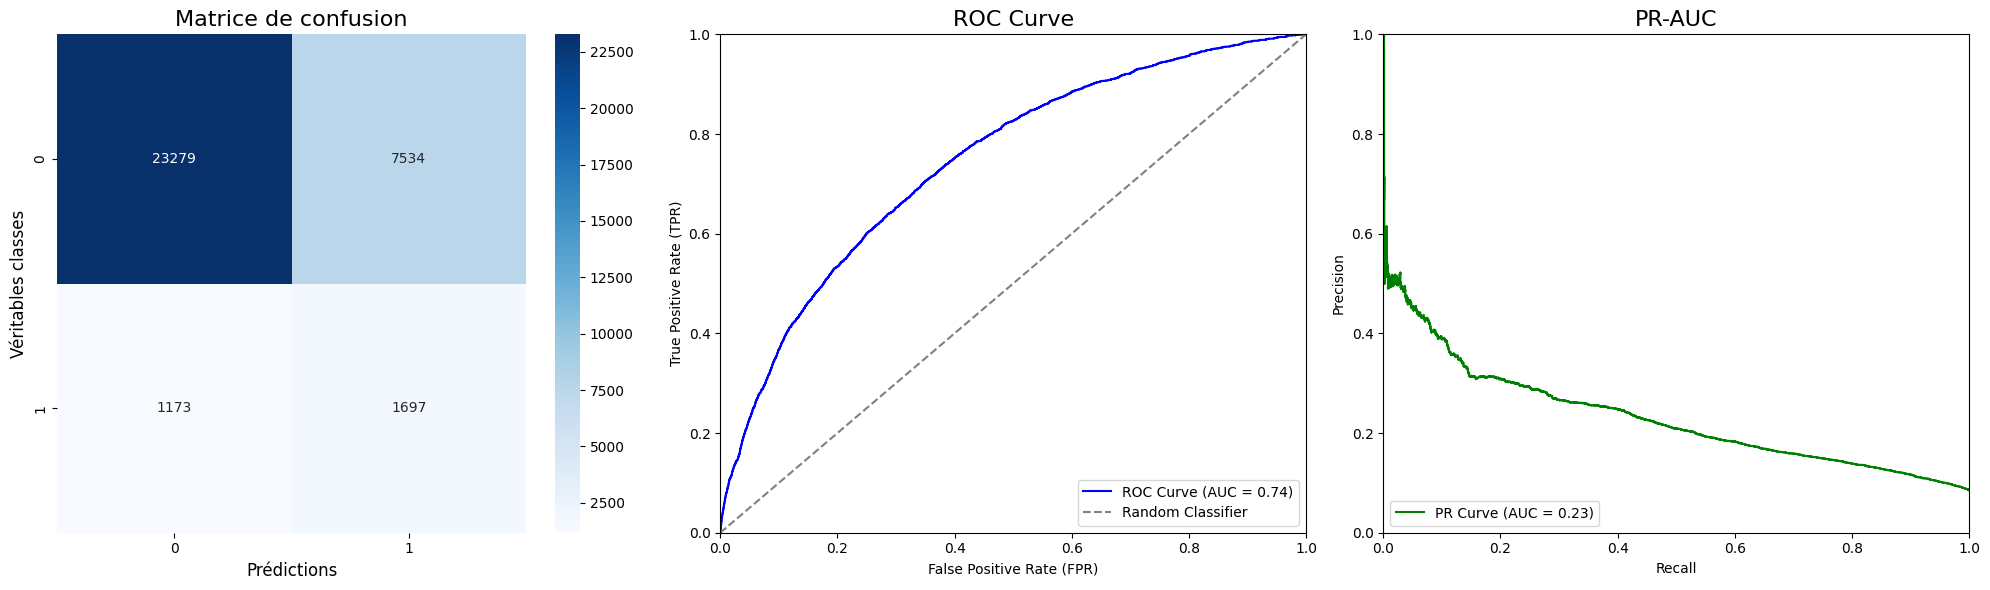

In [237]:
y_pred_lda = displayMetrics(lgb_optimized, X_test, y_test)

In [238]:
# # Fonction pour optimiser le seuil de prédiction
# def optimize_threshold(y_true, y_probs, num_thresholds=100):
#     """
#     Optimise le seuil de prédiction pour minimiser le coût métier.

#     Args:
#         y_true (array): Valeurs réelles des classes.
#         y_probs (array): Probabilités prédites par le modèle.
#         fn_weight (int): Poids attribué aux faux négatifs.
#         minority_class (int): Classe minoritaire (par défaut, 1).
#         num_thresholds (int): Nombre de seuils à tester (par défaut, 100).

#     Returns:
#         float: Meilleur seuil pour minimiser le coût métier.
#     """
#     thresholds = np.linspace(0, 1, num_thresholds)
#     best_threshold = 0.5
#     best_score = float('inf')

#     for threshold in thresholds:
#         y_pred = (y_probs >= threshold).astype(int)
#         score = custom_metric(y_true, y_pred)
#         if score < best_score:
#             best_score = score
#             best_threshold = threshold

#     return best_threshold


## Optimisation du seuil de confiance

In [239]:
def optimize_threshold(y_true, y_probs, fn_weight=10, minority_class=1, num_thresholds=10000):
    thresholds = np.linspace(0, 1, num_thresholds)
    best_threshold = 0.5
    min_cost = float('inf')

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        false_positives = ((y_pred == 1) & (y_true != minority_class)).sum()
        false_negatives = ((y_pred == 0) & (y_true == minority_class)).sum()
        cost = false_positives + fn_weight * false_negatives
        print(f"Seuil: {threshold:.2f}, Faux positifs: {false_positives}, Faux négatifs: {false_negatives}, Coût: {cost}")

        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold

    if min_cost == float('inf'):
        print("Aucun seuil optimal trouvé, retour du seuil par défaut : 0.5")
        return 0.5

    return best_threshold


In [240]:
# Probabilités pour la classe 1
y_probs = lgb_optimized.predict_proba(X_test)[:, 1]  


best_threshold = optimize_threshold(y_test, y_probs)
print(f"Meilleur seuil optimisé : {best_threshold}")


Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positifs: 30813, Faux négatifs: 0, Coût: 30813
Seuil: 0.00, Faux positif

c:\Users\223115316\Documents\GitHub\OC\Projet4\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\223115316\Documents\GitHub\OC\Projet4\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.Ou

Accuracy: 0.6845
F1 Score: 0.2644
Recall: 0.6655
Precision: 0.1650
Cohen's Kappa: 0.1481
MCC: 0.2068
Custom Metric: -17846.7940
ROC AUC: 0.7430
PR AUC: 0.2318


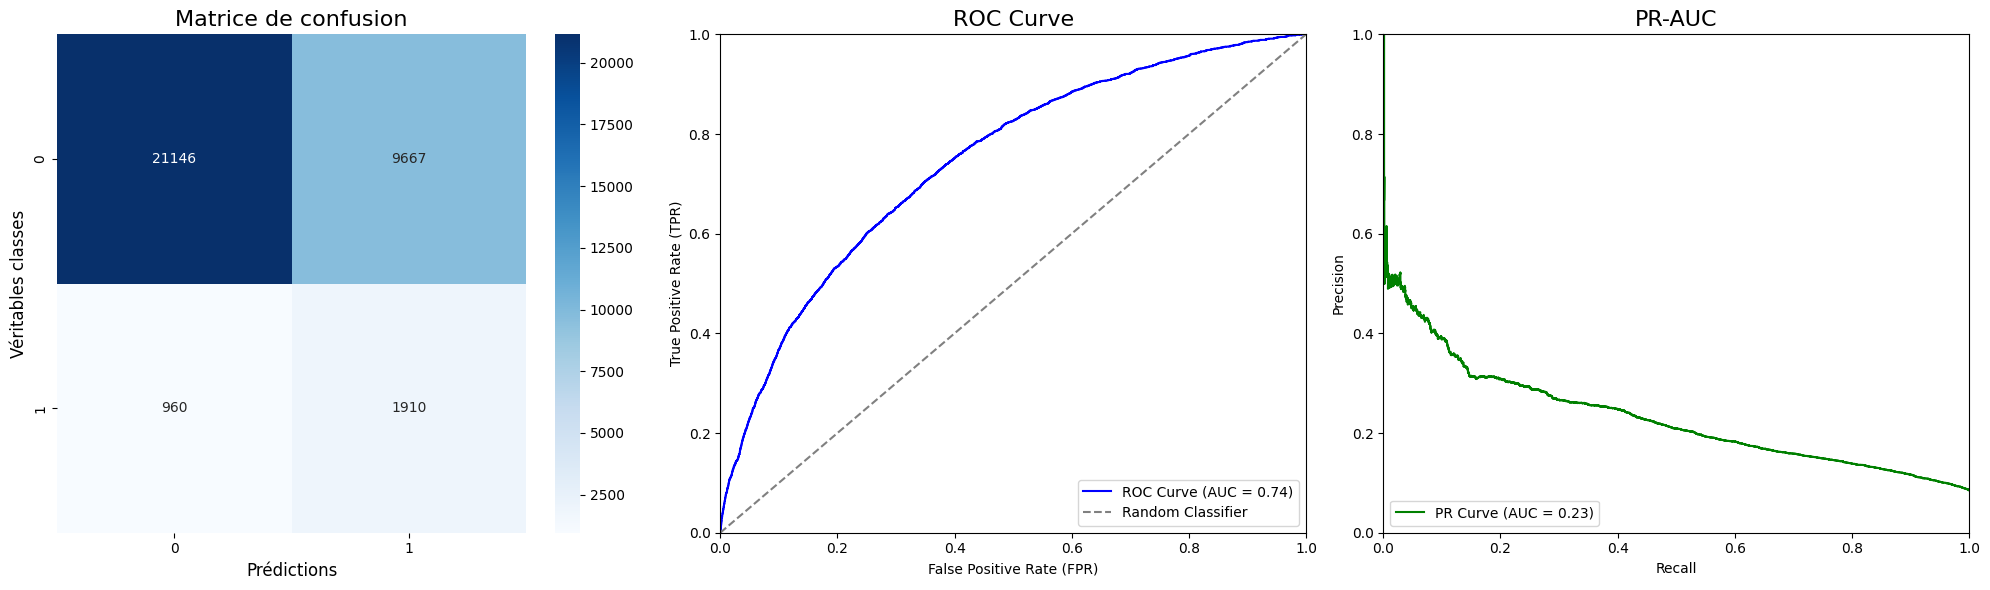

In [241]:
y_pred_lda = displayMetrics(lgb_optimized, X_test, y_test, confidence=best_threshold)

In [242]:
stop

NameError: name 'stop' is not defined

# <a id='toc3_'></a>[Explication du modèle avec SHAP](#toc0_)

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

In [18]:
explainer = shap.TreeExplainer(LGM)


In [19]:
shap_values = explainer(X_train)

In [ ]:
explainer

In [ ]:
shap_values

## Explication Globale

### Decision Plot

In [ ]:
# Exemple : Individu à expliquer
individu = [i for i in range(1000)]

# Valeurs SHAP pour cet individu
shap_values_ind = shap_values[individu].values  # Accéder aux valeurs sous-jacentes de l'objet SHAP

# Conversion en float64
shap_values_ind = shap_values_ind.astype('float64')

# Valeur de base (expected value)
base_value = float(explainer.expected_value)  # S'assurer que la base est aussi en float

# Données de l'individu (features)
features = X_train.iloc[individu].astype('float64')  # Conversion des données en float64

# Création du decision plot
shap.decision_plot(
    base_value=base_value,               # Valeur de base
    shap_values=shap_values_ind,         # Valeurs SHAP de l'individu
    feature_names=X_train.columns.tolist(),  # Noms des caractéristiques
    feature_order='importance'           # Tri des caractéristiques (optionnel)
)


### Heatmap

In [ ]:
# Correlation entre variable avec shap
shap.plots.heatmap(shap_values[:10000])  # Première tranche de 100 observations


### Bar plot

In [ ]:
shap.plots.bar(shap_values.abs.mean(0))

## Explication Locale

### Decision plot

In [ ]:
# Exemple : Individu à expliquer
individu = [0]

# Valeurs SHAP pour cet individu
shap_values_ind = shap_values[individu].values  # Accéder aux valeurs sous-jacentes de l'objet SHAP

# Conversion en float64
shap_values_ind = shap_values_ind.astype('float64')

# Valeur de base (expected value)
base_value = float(explainer.expected_value)  # S'assurer que la base est aussi en float

# Données de l'individu (features)
features = X_train.iloc[individu].astype('float64')  # Conversion des données en float64

# Création du decision plot
shap.decision_plot(
    base_value=base_value,               # Valeur de base
    shap_values=shap_values_ind,         # Valeurs SHAP de l'individu
    feature_names=X_train.columns.tolist(),  # Noms des caractéristiques
    feature_order='importance'           # Tri des caractéristiques (optionnel)
)


### Waterfall plot

In [ ]:
shap.plots.waterfall(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_train.iloc[0], feature_names=X_train.columns.tolist()))